Universidade Estadual de Campinas – UNICAMP 

Disciplina: Ciência e Visualização de Dados em Saúde

                    Análise de dados da hanseníase: uma abordagem preditiva para a saúde pública

# Imports e configs de módulos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import geopandas as gpd
import folium

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 70)
%matplotlib inline
sns.set_style('darkgrid')
sns.set(font_scale=1.005)

# Datasets

In [9]:
df_hans = pd.read_csv('../data/raw/hans_all_raw.csv')

C:\Users\maria.higino\AppData\Local\Temp\ipykernel_30456\2381453392.py:1: DtypeWarning: Columns (10,15,21,22,23,24,26,27,33,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hans = pd.read_csv('../data/raw/hans_all_raw.csv')


In [10]:
df_hans.head()

,TP_NOT,ID_AGRAVO,DT_NOTIFIC,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_DIAG,SEM_DIAG,ANO_NASC,NU_IDADE_N,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,SG_UF,ID_MN_RESI,ID_RG_RESI,ID_PAIS,NDUPLIC_N,DT_DIGITA,DT_TRANSUS,DT_TRANSDM,DT_TRANSSM,DT_TRANSRM,DT_TRANSRS,DT_TRANSSE,NU_LOTE_V,NU_LOTE_H,CS_FLXRET,FLXRECEBI,MIGRADO_W,ID_OCUPA_N,NU_LESOES,FORMACLINI,AVALIA_N,CLASSOPERA,MODOENTR,MODODETECT,BACILOSCOP,DTINICTRAT,ESQ_INI_N,CONTREG,NERVOSAFET,UFATUAL,ID_MUNI_AT,DT_NOTI_AT,ID_UNID_AT,UFRESAT,MUNIRESAT,DTULTCOMP,CLASSATUAL,AVAL_ATU_N,ESQ_ATU_N,DOSE_RECEB,EPIS_RACIO,DTMUDESQ,CONTEXAM,DTALTA_N,TPALTA_N,IN_VINCULA,NU_LOTE_IA
0,2,A309,10/01/2001,2001,41.0,410304,1359.0,2741474.0,10/12/2000,NaN,1942,4058,M,6.0,NaN,0.0,41.0,410304.0,1359.0,1.0,0.0,NaN,NaN,NaN,11/03/2008,NaN,NaN,22/05/2009,0.0,NaN,NaN,NaN,1.0,NaN,0.0,1.0,0.0,2.0,1.0,2.0,NaN,10/12/2000,3.0,0.0,NaN,PR,410304.0,10/01/2001,2741474.0,41.0,410304.0,02/10/2002,2.0,0.0,3.0,NaN,NaN,NaN,0.0,02/10/2002,1.0,0.0,0.0
1,2,A309,17/01/2001,2001,41.0,410940,1359.0,2741369.0,23/12/2000,NaN,1956,4044,M,6.0,1.0,0.0,41.0,410940.0,1359.0,1.0,0.0,NaN,NaN,NaN,28/12/2007,NaN,NaN,22/12/2010,0.0,NaN,NaN,NaN,1.0,NaN,0.0,4.0,2.0,2.0,6.0,NaN,NaN,17/01/2001,3.0,3.0,NaN,PR,410940.0,17/01/2001,2741369.0,41.0,410940.0,19/12/2001,2.0,0.0,3.0,NaN,NaN,NaN,2.0,19/12/2001,1.0,0.0,0.0
2,2,A309,16/01/2001,2001,41.0,410940,1359.0,2741369.0,16/01/2001,NaN,1968,4032,M,6.0,1.0,3.0,41.0,410940.0,1359.0,1.0,0.0,NaN,NaN,NaN,28/12/2007,NaN,NaN,22/12/2010,0.0,NaN,NaN,NaN,1.0,NaN,0.0,2.0,0.0,1.0,1.0,1.0,NaN,16/01/2001,1.0,1.0,NaN,PR,410940.0,16/01/2001,2741369.0,41.0,410940.0,27/06/2001,1.0,0.0,1.0,NaN,NaN,NaN,1.0,27/06/2001,1.0,0.0,0.0
3,2,A309,08/01/2001,2001,41.0,411780,1359.0,2743116.0,08/01/2001,NaN,1960,4040,F,9.0,NaN,3.0,41.0,411780.0,1359.0,1.0,0.0,NaN,NaN,NaN,10/12/2007,NaN,NaN,22/12/2010,0.0,NaN,NaN,NaN,1.0,NaN,0.0,1.0,1.0,2.0,1.0,2.0,NaN,08/01/2001,3.0,3.0,NaN,PR,411780.0,08/01/2001,2743116.0,41.0,411780.0,28/01/2002,2.0,0.0,3.0,NaN,NaN,NaN,3.0,28/01/2002,1.0,0.0,0.0
4,2,A309,02/01/2001,2001,41.0,411780,1359.0,2743116.0,11/01/2000,NaN,1968,4031,M,6.0,NaN,0.0,41.0,411780.0,1359.0,1.0,0.0,NaN,NaN,NaN,10/12/2007,NaN,NaN,22/12/2010,0.0,NaN,NaN,NaN,1.0,NaN,0.0,4.0,1.0,2.0,3.0,NaN,NaN,02/01/2001,3.0,0.0,NaN,PR,411780.0,02/01/2001,2743116.0,41.0,411780.0,14/03/2002,2.0,2.0,3.0,NaN,NaN,NaN,0.0,14/03/2002,1.0,0.0,0.0


In [11]:
df_hans.shape

(923411, 63)

### Pandas Profiling

In [12]:
profile = ProfileReport(df_hans, title='Report', correlations={
                                                "pearson": {"calculate": False},
                                                "spearman": {"calculate": False},
                                                "kendall": {"calculate": False},
                                                "phi_k": {"calculate": False},
                                                "cramers": {"calculate": False}},
                                             missing_diagrams={
                                                "heatmap": False,
                                                "dendrogram": False,
                                                "matrix": False,
                                                "bar": False},
                                             interactions={
                                                "continuous": False})

In [13]:
profile.to_file("../assets/reports/report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# EDA

### Análise de casos por ano

In [14]:
df_hans['NU_ANO'].value_counts().sort_index()

2001    50672
2002    55112
2003    58887
2004    57540
2005    56751
2006    52251
2007    47095
2008    47482
2009    44958
2010    42636
2011    41493
2012    40898
2013    38262
2014    38446
2015    36055
2016    32330
2017    34926
2018    36772
2019    36626
2020    23775
2021    24957
2022    25487
Name: NU_ANO, dtype: int64

<AxesSubplot:>

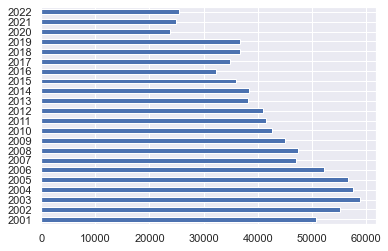

In [15]:
df_hans['NU_ANO'].value_counts().sort_index().plot.barh()

### Análise de casos por estado

In [16]:
df_hans_states = df_hans['UFATUAL'].value_counts().to_frame().reset_index()
df_hans_states = df_hans_states.rename(columns={'index': 'UF', 'UFATUAL': 'Contagem'})
df_hans_states.head()

,UF,Contagem
0,MA,102443
1,PA,100359
2,MT,83517
3,PE,71028
4,BA,66414


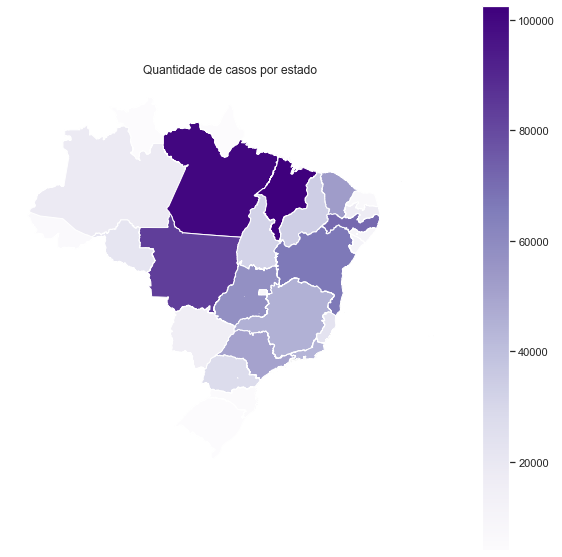

In [17]:
# Carrega o arquivo shapefile do mapa do Brasil
map = gpd.read_file('../assets/mapa/BR_UF_2022.shp')

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences = map.merge(df_hans_states, left_on='SIGLA_UF', right_on='UF')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences.plot(column='Contagem', cmap='Purples', ax=ax, legend=True)
ax.set_title('Quantidade de casos por estado')
ax.set_axis_off()
plt.show()

### Análise de casos por estado e gravidade

In [18]:
df_hans_severity = df_hans.groupby(['UFATUAL', 'AVALIA_N']).size().reset_index(name='Contagem')
df_hans_severity.head()

,UFATUAL,AVALIA_N,Contagem
0,AC,0.0,4427
1,AC,1.0,866
2,AC,2.0,387
3,AC,3.0,84
4,AL,0.0,5128


#### Grau 0:

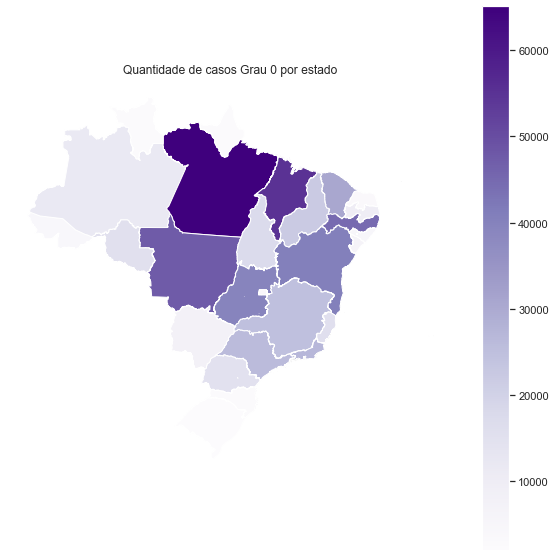

In [19]:
df_hans_severity_0 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 0].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_0 = map.merge(df_hans_severity_0, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_0.plot(column='Contagem', cmap='Purples', ax=ax, legend=True)
ax.set_title('Quantidade de casos Grau 0 por estado')
ax.set_axis_off()
plt.show()

#### Grau I:

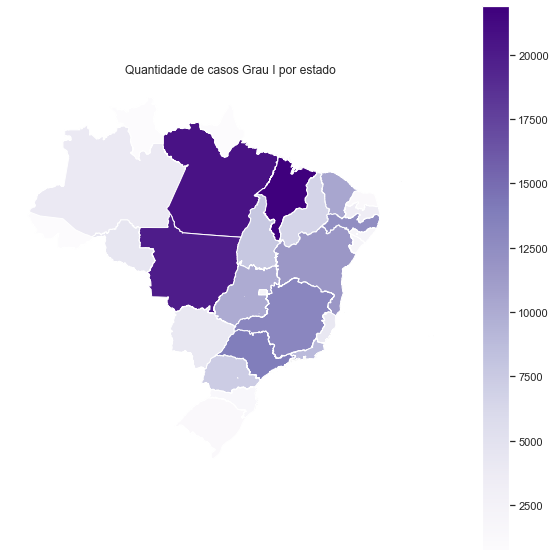

In [20]:
df_hans_severity_1 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 1].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_1 = map.merge(df_hans_severity_1, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_1.plot(column='Contagem', cmap='Purples', ax=ax, legend=True)
ax.set_title('Quantidade de casos Grau I por estado')
ax.set_axis_off()
plt.show()

#### Grau II:

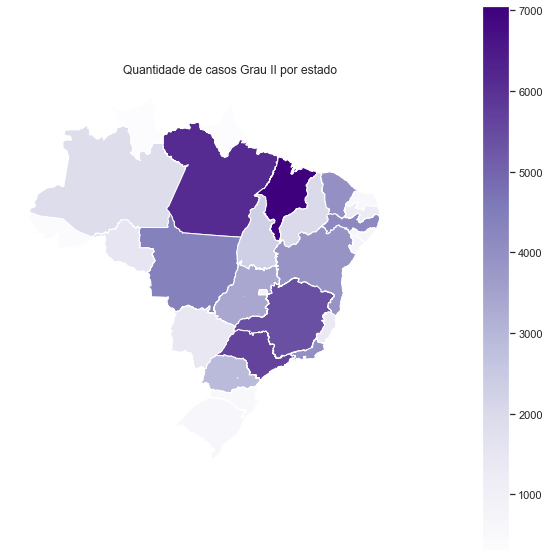

In [21]:
df_hans_severity_2 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 2].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_2 = map.merge(df_hans_severity_2, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_2.plot(column='Contagem', cmap='Purples', ax=ax, legend=True)
ax.set_title('Quantidade de casos Grau II por estado')
ax.set_axis_off()
plt.show()